In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# infant fs : need 24 GB per subject => 이것에 맞도록 -n -N option제ㅐ돌 ㅗ디도록 하기
# -n -N이 특정 subject skip경우 있던데 왜그런지 찾아보기 (n*N = total number of jobs 이 수학적으로 딱 divisable해야하나?

# one thing to make : DWI가 너무 많거나(mrcat)하기 , T1,T2, DWI중 하나가 없는 경우 (tree의 length로 보면될듯) 등을 해결해야함! (그 폴더들을, "mrcat나중에 하기", "missing DWI, T1 or T2"로 두가지로 분류해서 넣기!) 
(밑의 것을 package화시켜서 여러개로 돌리면, 위의 것들도 해결해놓기!) ("QA/QC check"이라는 이름으로)

* freeusrfer launchber로 돌리면 이상하게 몇개는 그 중복되어서 되어서 안되는 경우가 있다.. (내가 그 github issue올리기는 했는데 아직 답변이 없다 ㅋㅋㅋ) => 이것 만약 해결안된다면, freesurfer tree갯수 세서, QA/QC한다음에 다시 돌리는 것을 하던지 해야할듯 

In [2]:
import os
import subprocess
import argparse
from pathlib import Path
import pdb
from glob import glob 
import warnings


######IMPORTANT TO SELECT THIS########
ntasks_per_node = 24#48 #node당 몇명을 할지 (have to be optimized so memory error doeens't occur)
node = "icx"#"skx" #or "icx"

######################################
if node	== "skx":
    total_cpu =	96 #count of total cpus
elif node == "icx":
    total_cpu =	160
elif node == "flat-quadrant":
    total_cpu = 240
nthreads_per_sub = int(total_cpu/ntasks_per_node)

#######ASSUMPTIONS######
curr_dir = os.getcwd()
#args : one BIDS directory to run (we will for loop over this)
#needs age_dict if needed 
class Args():
    def __init__(self, scratch_dir, save_dir ,shell_name,age_df = None, T2 = False, optional_BIDS_folder = None ):
        """
        scratch_dir : 이 디렉토리에다가 freesurfer결과들을 저장하고 할 것이다. 
            주의 : scratch_dir의 "2.BIDS"라는 폴더내에 BDIS포맷으로 들어있어야한다!
        age_df : None if BIDS has no infant, or else, dataframe of age must be provided (if true, infant freesurfer사용한다)
        T2 : T2 여부 (default : false)(if true, T2 도 쓰는 freesurfer 버젼을 쓴다 )
        """
        self.base_dir = Path(curr_dir)
        self.scratch_dir = Path(scratch_dir) #where the BIDS and outputs are and will be saved
        
        if os.path.exists(self.scratch_dir / '2.BIDS') :
            self.BIDS_dir = Path(self.scratch_dir/'2.BIDS') #MUST BE MODIFIED TO THE INPUT I WANT TO RUN WITH
        else : 
            if optional_BIDS_folder:
                self.BIDS_dir = Path(self.scratch_dir/optional_BIDS_folder)
            else :
                self.BIDS_dir = Path(self.scratch_dir)
        
        
        self.save_dir = Path(save_dir)
        
        self.shell_name = shell_name
        #self.save_dir = Path(self.scratch_dir/'3.FS_results')
        self.supp_dir = Path('/work2/08834/tg881334/stampede2/CHA_preproc/docker') #directory where the singularity images and etc are held
        self.shell_dir = Path(self.base_dir / f'{self.shell_name}/run_this') #where the shelll scripts for each subject will be saved
        self.log_dir = Path(self.base_dir/f'{self.shell_name}/log_outputs')
        
        self.sub_list = [file for file in sorted(os.listdir(self.BIDS_dir)) if 'sub-' in file] #only if sub file 
        
        
        
        self.nthreads_per_sub = nthreads_per_sub
        
        ##choosing which freesurfer version to run (with T2? infant version? )
        self.T2 = T2
        
        #choosing if to use infant freesurfer (and if so, saving their ages)
        if age_df is not None: #i.e. not False/None #from https://stackoverflow.com/questions/39337115/testing-if-a-pandas-dataframe-exists
            self.infant = True
            age_list = []
            for sub in self.sub_list:
                age_list.append(float(age_df[age_df['영상파일 번호'] == sub]["age"].values))
            self.age_list = age_list
        else :
            self.infant = None #do NOT use infant freesurfer at all!

In [3]:
class recon_all():
    def __init__(self, args):
        #didn't use super as it inhertis from class, not the class "instance"
        #https://stackoverflow.com/questions/62625460/how-to-inherit-from-pre-existing-class-instance-in-python
        vars(self).update(vars(args)) #inherit attributes from args (by making it into dict, then updating the dict)
        
        if args.infant : #i.e. if not none (use infant fs)
            self.mode = "infant_fs"
            self.sing_img_dir = self.supp_dir / "infant_fs_sandbox"
        else :  #(use default, adult fs )
            self.sing_img_dir = self.supp_dir / "freesurfer_7.3.2.sif"
            if args.T2:
                self.mode = "T2_fs"
            else : 
                self.mode = "default_fs"
    
    def make_scripts(self):
        os.makedirs(self.shell_dir, exist_ok = True)
        for i,sub in enumerate(self.sub_list):
            print(f"creating freesurfer .sh for subject : {sub}")            
            ##first, setup directories for running freesurfer ()
            #use glob to find the T1 directory from the thing 

            #below : looked at https://stackoverflow.com/questions/14798220/how-can-i-search-sub-folders-using-glob-glob-module
            #이렇게 한 이유 : session정보여부 상관없이 잘 돌아가도록 하기 위해ㅓㅅ 
            sub_T1_dir = glob(str(self.BIDS_dir / sub)+"/**/anat/*_T1w.nii*", recursive = True)[0] #[0] because we want the string it self
            
            #optionally find T2 dir if T2 == True (밑에서 exception했는데, 그 이유는 BIDS에서 가끔씩 T2가 없는 경우도 있어서, 그 경우 에러가아닌 warning만 내도록 하려고 )
            try : 
                sub_T2_dir = glob(str(self.BIDS_dir / sub)+"/**/anat/*_T2w.nii*", recursive = True)[0] if self.T2 else None
            except : 
                warnings.warn(f"subject : {sub} not done, probably becasue T2 image doesn't exist for this subject ")
            
            bash_shell = ["#! /bin/bash", "module load tacc-singularity"]            
         
            upper_dir, T1_file= os.path.split(sub_T1_dir)
            T2_file = os.path.split(sub_T2_dir)[1] if self.T2 else None 
            
            if self.infant : #i.e. infant fs
                bash_shell.append(f"export SUBJECT={sub}")
                
                #copy the files and rename them to mprange because of the infant freesurfer requirement
                destination = f"/tmp/data/{sub}"
                bash_shell.append(f'mkdir -p {destination}')#make sure that the destination exists
                bash_shell.append(f"cp {sub_T1_dir} {destination}/mprage.nii.gz")
                
                age_month = 12*self.age_list[i] #age in months
                singularity_command = "singularity run -B" \
                "/work2/08834/tg881334/stampede2/infant_FS:/supp," \
                "/tmp:/tmp" \
                " --env SUBJECTS_DIR=/tmp/data" \
                " /work2/08834/tg881334/stampede2/CHA_preproc/docker/infant_fs_sandbox" \
                f" infant_recon_all  --s {sub} --outdir /tmp/{sub} --age {round(age_month)}" #round age because only integer month values can be given
                
                
                #raise NotImplementedError("infant freesurfer not implemented yet")
            else: #use /tmp since that's faster (ssd directly on the node)
                singularity_command = "singularity run -B" \
                f" {upper_dir}:/data," \
                "/work2/08834/tg881334/stampede2/infant_FS:/supp," \
                "/tmp:/tmp" \
                " --env FS_LICENSE=/supp/license.txt" \
                " /work2/08834/tg881334/stampede2/CHA_preproc/docker/freesurfer_7.1.1.sif" \
                " recon-all -sd /tmp" \
                          f" -i /data/{T1_file}" \
                          f" -s {sub}" \
                          f" -all -parallel -openmp {self.nthreads_per_sub} -no-isrunning" 
                 #single str multiple line :  https://stackoverflow.com/questions/10660435/how-do-i-split-the-definition-of-a-long-string-over-multiple-lines
                 #beware of the space infront:  when to space and when to not 
                
                if self.T2==True : singularity_command = singularity_command + f' -T2 /data/{T2_file} -T2pial' ##T2면, reconall 옵션 추가

            bash_shell.append(singularity_command) #add the singularity command            
            bash_shell += [f'cd /tmp', f'tar -cvf {sub}.tar {sub}', f'cp {sub}.tar {self.save_dir}']
                        #save and move the file 
                        
            ##saving the shell files(the bash shell list into an actual bash shell script)
            with open(f"{self.shell_dir}/run_shell_{sub}.sh", "a") as f:
                for line in bash_shell:
                    f.write(f"{line}\n")            
        
        #make script to launch launcher (particular to tacc. slurm job array is also possible, though code modifications required)
        os.makedirs(self.log_dir, exist_ok = True)
        for sub_shell in os.listdir(self.shell_dir):
            shell_to_run = os.path.join(self.shell_dir, sub_shell)
            sub_id = sub_shell.split('-')[-1][:-3]
            command_to_add = shell_to_run + f" >> {self.log_dir}/output-${{LAUNCHER_TSK_ID}}_sub-{sub_id}"
            
            with open(f"{self.base_dir}/{self.shell_name}/qsipreproc_command_list.txt", "a") as f:
                f.write(f"{command_to_add}\n")
                
                
        #밑 : 나중에 run_script위치로 바꿔야함.. 일단은 생략
        subprocess.run(f"chmod 755 {self.shell_dir}/*", shell = True) #돌릴 수 있도록 permission change

    def run_script():
        subprocess.run(f"chmod 755 {self.shell_dir}/*", shell = True) #돌릴 수 있도록 permission change
        
        return sub_T1_dir, sub_T2_dir, bash_shell, self.nthreads_per_sub, sub

In [4]:
##actual runnign (need to implement saving/infant df, and so on too)
#abcd_fs = Args(scratch_dir= '/scratch/08834/tg881334/2019', save_dir="/scratch/08834/tg881334/2019/3.FS_tar/",shell_name = "step1_abcd_fs",T2 = True)

#optional_BIDS_folder로 custom bids folder 지정!



In [10]:
## doing ABCD
glob_pattern = "Y-Z*" ##CHANGED THIS TOO
scratch_dir = '/scratch/08834/tg881334/ABCD_preproc/2.BIDS/NDARINVY-Z/'
save_dir =  f'/scratch/08834/tg881334/ABCD_preproc/3.FS_tar/NDARINVY-Z'
#folder_list = glob(scratch_dir)
os.makedirs(save_dir, exist_ok=True)


ABCD_fs = Args(scratch_dir = scratch_dir,
    save_dir= save_dir, shell_name=f"step1_ABCD_fs_NDARINV{glob_pattern[:-1]}",
    T2= True)


recon_all(ABCD_fs).make_scripts()


creating freesurfer .sh for subject : sub-NDARINVY03A7Z27
creating freesurfer .sh for subject : sub-NDARINVY09XGV2D
creating freesurfer .sh for subject : sub-NDARINVY0M892WU
creating freesurfer .sh for subject : sub-NDARINVY0M8DA4H
creating freesurfer .sh for subject : sub-NDARINVY0MJVZ0T
creating freesurfer .sh for subject : sub-NDARINVY0RZGBNN
creating freesurfer .sh for subject : sub-NDARINVY0YM6R2T
creating freesurfer .sh for subject : sub-NDARINVY17ZU37V
creating freesurfer .sh for subject : sub-NDARINVY19AMXWK
creating freesurfer .sh for subject : sub-NDARINVY19N2XDD
creating freesurfer .sh for subject : sub-NDARINVY1B9FTLD
creating freesurfer .sh for subject : sub-NDARINVY1D0KCY0
creating freesurfer .sh for subject : sub-NDARINVY1HUK71Z
creating freesurfer .sh for subject : sub-NDARINVY1KBMF25
creating freesurfer .sh for subject : sub-NDARINVY1V92JT2
creating freesurfer .sh for subject : sub-NDARINVY2B2659F
creating freesurfer .sh for subject : sub-NDARINVY2BPM655
creating frees

/tmp/ipykernel_327319/879456222.py:32: UserWarning: subject : sub-NDARINVY5V81D0R not done, probably becasue T2 image doesn't exist for this subject 
  warnings.warn(f"subject : {sub} not done, probably becasue T2 image doesn't exist for this subject ")
/tmp/ipykernel_327319/879456222.py:32: UserWarning: subject : sub-NDARINVY88VF9K2 not done, probably becasue T2 image doesn't exist for this subject 
  warnings.warn(f"subject : {sub} not done, probably becasue T2 image doesn't exist for this subject ")
/tmp/ipykernel_327319/879456222.py:32: UserWarning: subject : sub-NDARINVYACN0D32 not done, probably becasue T2 image doesn't exist for this subject 
  warnings.warn(f"subject : {sub} not done, probably becasue T2 image doesn't exist for this subject ")


creating freesurfer .sh for subject : sub-NDARINVY9308Z24
creating freesurfer .sh for subject : sub-NDARINVY956TX1N
creating freesurfer .sh for subject : sub-NDARINVY98NL5JN
creating freesurfer .sh for subject : sub-NDARINVY9DCYBXW
creating freesurfer .sh for subject : sub-NDARINVY9FMUL8B
creating freesurfer .sh for subject : sub-NDARINVY9K2AGV1
creating freesurfer .sh for subject : sub-NDARINVY9YA660C
creating freesurfer .sh for subject : sub-NDARINVYA6B3A5N
creating freesurfer .sh for subject : sub-NDARINVYACN0D32
creating freesurfer .sh for subject : sub-NDARINVYAEE6YN4
creating freesurfer .sh for subject : sub-NDARINVYAVZM6F1
creating freesurfer .sh for subject : sub-NDARINVYB10EE8B
creating freesurfer .sh for subject : sub-NDARINVYBBAHJWV
creating freesurfer .sh for subject : sub-NDARINVYBC941EU
creating freesurfer .sh for subject : sub-NDARINVYBKC8W12
creating freesurfer .sh for subject : sub-NDARINVYBPN1YEU
creating freesurfer .sh for subject : sub-NDARINVYBPWDCF6
creating frees

/tmp/ipykernel_327319/879456222.py:32: UserWarning: subject : sub-NDARINVYHRM6MHF not done, probably becasue T2 image doesn't exist for this subject 
  warnings.warn(f"subject : {sub} not done, probably becasue T2 image doesn't exist for this subject ")


creating freesurfer .sh for subject : sub-NDARINVYKVPYY2M
creating freesurfer .sh for subject : sub-NDARINVYKWMEWGG
creating freesurfer .sh for subject : sub-NDARINVYL2LMJ28
creating freesurfer .sh for subject : sub-NDARINVYL42LJHV
creating freesurfer .sh for subject : sub-NDARINVYLKWWGJ2
creating freesurfer .sh for subject : sub-NDARINVYLM67JAJ
creating freesurfer .sh for subject : sub-NDARINVYLR06LF1
creating freesurfer .sh for subject : sub-NDARINVYLR246GE
creating freesurfer .sh for subject : sub-NDARINVYLTE2PT9
creating freesurfer .sh for subject : sub-NDARINVYM29ZAGR
creating freesurfer .sh for subject : sub-NDARINVYM9J1XYN
creating freesurfer .sh for subject : sub-NDARINVYMAZAYYB
creating freesurfer .sh for subject : sub-NDARINVYME882GP
creating freesurfer .sh for subject : sub-NDARINVYMG44FLN
creating freesurfer .sh for subject : sub-NDARINVYMM66RPJ
creating freesurfer .sh for subject : sub-NDARINVYMMRDKJW
creating freesurfer .sh for subject : sub-NDARINVYMPEHMMT
creating frees

/tmp/ipykernel_327319/879456222.py:32: UserWarning: subject : sub-NDARINVYT7M0T6Y not done, probably becasue T2 image doesn't exist for this subject 
  warnings.warn(f"subject : {sub} not done, probably becasue T2 image doesn't exist for this subject ")
/tmp/ipykernel_327319/879456222.py:32: UserWarning: subject : sub-NDARINVYUPPEV2G not done, probably becasue T2 image doesn't exist for this subject 
  warnings.warn(f"subject : {sub} not done, probably becasue T2 image doesn't exist for this subject ")
/tmp/ipykernel_327319/879456222.py:32: UserWarning: subject : sub-NDARINVYVVMMD41 not done, probably becasue T2 image doesn't exist for this subject 
  warnings.warn(f"subject : {sub} not done, probably becasue T2 image doesn't exist for this subject ")


creating freesurfer .sh for subject : sub-NDARINVYXHBN74V
creating freesurfer .sh for subject : sub-NDARINVYXMFACD7
creating freesurfer .sh for subject : sub-NDARINVYXRGTMYM
creating freesurfer .sh for subject : sub-NDARINVYY0HHPV2
creating freesurfer .sh for subject : sub-NDARINVYY60EGDK
creating freesurfer .sh for subject : sub-NDARINVYY9NRYW2
creating freesurfer .sh for subject : sub-NDARINVYYBL28AM
creating freesurfer .sh for subject : sub-NDARINVYYTGPBJA
creating freesurfer .sh for subject : sub-NDARINVYZ0U1DGC
creating freesurfer .sh for subject : sub-NDARINVYZ0ZBG85
creating freesurfer .sh for subject : sub-NDARINVYZ353ZBM
creating freesurfer .sh for subject : sub-NDARINVYZFMM6MW
creating freesurfer .sh for subject : sub-NDARINVYZJRWG4A
creating freesurfer .sh for subject : sub-NDARINVYZPP72NK
creating freesurfer .sh for subject : sub-NDARINVYZURN14T
creating freesurfer .sh for subject : sub-NDARINVZ02PLW9B
creating freesurfer .sh for subject : sub-NDARINVZ04GJXZA
creating frees

/tmp/ipykernel_327319/879456222.py:32: UserWarning: subject : sub-NDARINVZ0A9V1XA not done, probably becasue T2 image doesn't exist for this subject 
  warnings.warn(f"subject : {sub} not done, probably becasue T2 image doesn't exist for this subject ")


creating freesurfer .sh for subject : sub-NDARINVZ0MP06TT
creating freesurfer .sh for subject : sub-NDARINVZ0MXU52L
creating freesurfer .sh for subject : sub-NDARINVZ0NPTXMB
creating freesurfer .sh for subject : sub-NDARINVZ0RUM99Y
creating freesurfer .sh for subject : sub-NDARINVZ0TL0G08
creating freesurfer .sh for subject : sub-NDARINVZ0XNHVW8
creating freesurfer .sh for subject : sub-NDARINVZ174YN3F
creating freesurfer .sh for subject : sub-NDARINVZ18FPVFJ
creating freesurfer .sh for subject : sub-NDARINVZ1A6W085
creating freesurfer .sh for subject : sub-NDARINVZ1B2P1NH
creating freesurfer .sh for subject : sub-NDARINVZ1GFV0R4
creating freesurfer .sh for subject : sub-NDARINVZ1KX2326
creating freesurfer .sh for subject : sub-NDARINVZ1V6MUBA
creating freesurfer .sh for subject : sub-NDARINVZ1WZW3KT
creating freesurfer .sh for subject : sub-NDARINVZ1Z285F2
creating freesurfer .sh for subject : sub-NDARINVZ20Z6JR3
creating freesurfer .sh for subject : sub-NDARINVZ2KNBAKB
creating frees

/tmp/ipykernel_327319/879456222.py:32: UserWarning: subject : sub-NDARINVZ1KX2326 not done, probably becasue T2 image doesn't exist for this subject 
  warnings.warn(f"subject : {sub} not done, probably becasue T2 image doesn't exist for this subject ")
/tmp/ipykernel_327319/879456222.py:32: UserWarning: subject : sub-NDARINVZ1Z285F2 not done, probably becasue T2 image doesn't exist for this subject 
  warnings.warn(f"subject : {sub} not done, probably becasue T2 image doesn't exist for this subject ")
/tmp/ipykernel_327319/879456222.py:32: UserWarning: subject : sub-NDARINVZ6950R7M not done, probably becasue T2 image doesn't exist for this subject 
  warnings.warn(f"subject : {sub} not done, probably becasue T2 image doesn't exist for this subject ")
/tmp/ipykernel_327319/879456222.py:32: UserWarning: subject : sub-NDARINVZ6X7VT6J not done, probably becasue T2 image doesn't exist for this subject 
  warnings.warn(f"subject : {sub} not done, probably becasue T2 image doesn't exist for 

creating freesurfer .sh for subject : sub-NDARINVZ5T7BWT5
creating freesurfer .sh for subject : sub-NDARINVZ62Y3LZB
creating freesurfer .sh for subject : sub-NDARINVZ658LRCT
creating freesurfer .sh for subject : sub-NDARINVZ694ZZUM
creating freesurfer .sh for subject : sub-NDARINVZ6950R7M
creating freesurfer .sh for subject : sub-NDARINVZ6EXYCV3
creating freesurfer .sh for subject : sub-NDARINVZ6TDLDW8
creating freesurfer .sh for subject : sub-NDARINVZ6X7VT6J
creating freesurfer .sh for subject : sub-NDARINVZ6Z9DP4H
creating freesurfer .sh for subject : sub-NDARINVZ6ZN350N
creating freesurfer .sh for subject : sub-NDARINVZ6ZWJ1W6
creating freesurfer .sh for subject : sub-NDARINVZ730VLUZ
creating freesurfer .sh for subject : sub-NDARINVZ7FR6UCT
creating freesurfer .sh for subject : sub-NDARINVZ7U9A2DX
creating freesurfer .sh for subject : sub-NDARINVZ85UEYE5
creating freesurfer .sh for subject : sub-NDARINVZ8JNGWDY
creating freesurfer .sh for subject : sub-NDARINVZ8U8TUHJ
creating frees

/tmp/ipykernel_327319/879456222.py:32: UserWarning: subject : sub-NDARINVZBLU9Z3A not done, probably becasue T2 image doesn't exist for this subject 
  warnings.warn(f"subject : {sub} not done, probably becasue T2 image doesn't exist for this subject ")
/tmp/ipykernel_327319/879456222.py:32: UserWarning: subject : sub-NDARINVZCCLLLCW not done, probably becasue T2 image doesn't exist for this subject 
  warnings.warn(f"subject : {sub} not done, probably becasue T2 image doesn't exist for this subject ")


creating freesurfer .sh for subject : sub-NDARINVZFGU643V
creating freesurfer .sh for subject : sub-NDARINVZFYGCHKB
creating freesurfer .sh for subject : sub-NDARINVZG3E0W8V
creating freesurfer .sh for subject : sub-NDARINVZG4U8G7X
creating freesurfer .sh for subject : sub-NDARINVZG6365BX
creating freesurfer .sh for subject : sub-NDARINVZG6DB5BV
creating freesurfer .sh for subject : sub-NDARINVZGDMXH98
creating freesurfer .sh for subject : sub-NDARINVZGEEAXPZ
creating freesurfer .sh for subject : sub-NDARINVZGLD1V00
creating freesurfer .sh for subject : sub-NDARINVZGT6YAX7
creating freesurfer .sh for subject : sub-NDARINVZGWMJWB5
creating freesurfer .sh for subject : sub-NDARINVZHC9WP9J
creating freesurfer .sh for subject : sub-NDARINVZHCK39Y1
creating freesurfer .sh for subject : sub-NDARINVZHF0XGK3
creating freesurfer .sh for subject : sub-NDARINVZHZZXCM0
creating freesurfer .sh for subject : sub-NDARINVZJ8TBWKJ
creating freesurfer .sh for subject : sub-NDARINVZJB6P8ZB
creating frees

/tmp/ipykernel_327319/879456222.py:32: UserWarning: subject : sub-NDARINVZGWMJWB5 not done, probably becasue T2 image doesn't exist for this subject 
  warnings.warn(f"subject : {sub} not done, probably becasue T2 image doesn't exist for this subject ")


creating freesurfer .sh for subject : sub-NDARINVZJKN66UT
creating freesurfer .sh for subject : sub-NDARINVZJPA44D2
creating freesurfer .sh for subject : sub-NDARINVZJUBWF3F
creating freesurfer .sh for subject : sub-NDARINVZJUUZAPJ
creating freesurfer .sh for subject : sub-NDARINVZJV3HZEF
creating freesurfer .sh for subject : sub-NDARINVZJYGP0WE
creating freesurfer .sh for subject : sub-NDARINVZK4B9G7W
creating freesurfer .sh for subject : sub-NDARINVZKBLKU16
creating freesurfer .sh for subject : sub-NDARINVZKG5FH02
creating freesurfer .sh for subject : sub-NDARINVZKJXBJMM
creating freesurfer .sh for subject : sub-NDARINVZKP2G8H4
creating freesurfer .sh for subject : sub-NDARINVZKT1BV8Y
creating freesurfer .sh for subject : sub-NDARINVZKYLLADV
creating freesurfer .sh for subject : sub-NDARINVZL6CFV5G
creating freesurfer .sh for subject : sub-NDARINVZLG67H4Z
creating freesurfer .sh for subject : sub-NDARINVZLL8B2MA
creating freesurfer .sh for subject : sub-NDARINVZLP46GRP
creating frees

/tmp/ipykernel_327319/879456222.py:32: UserWarning: subject : sub-NDARINVZPCU8GG3 not done, probably becasue T2 image doesn't exist for this subject 
  warnings.warn(f"subject : {sub} not done, probably becasue T2 image doesn't exist for this subject ")
/tmp/ipykernel_327319/879456222.py:32: UserWarning: subject : sub-NDARINVZRBMFHKB not done, probably becasue T2 image doesn't exist for this subject 
  warnings.warn(f"subject : {sub} not done, probably becasue T2 image doesn't exist for this subject ")


creating freesurfer .sh for subject : sub-NDARINVZTEBGFLA
creating freesurfer .sh for subject : sub-NDARINVZTFAZ4PF
creating freesurfer .sh for subject : sub-NDARINVZTP2ZHLN
creating freesurfer .sh for subject : sub-NDARINVZTPV9V4Z
creating freesurfer .sh for subject : sub-NDARINVZTTGYL51
creating freesurfer .sh for subject : sub-NDARINVZTWTFU2A
creating freesurfer .sh for subject : sub-NDARINVZUDPGDWJ
creating freesurfer .sh for subject : sub-NDARINVZUGVEHNK
creating freesurfer .sh for subject : sub-NDARINVZUXFF006
creating freesurfer .sh for subject : sub-NDARINVZUXHPX3N
creating freesurfer .sh for subject : sub-NDARINVZV54BWRE
creating freesurfer .sh for subject : sub-NDARINVZVD13ZMG
creating freesurfer .sh for subject : sub-NDARINVZVGAMFG7
creating freesurfer .sh for subject : sub-NDARINVZVK7PB78
creating freesurfer .sh for subject : sub-NDARINVZVNYXUNB
creating freesurfer .sh for subject : sub-NDARINVZVW3HKWN
creating freesurfer .sh for subject : sub-NDARINVZVYCX57J
creating frees

/tmp/ipykernel_327319/879456222.py:32: UserWarning: subject : sub-NDARINVZUGVEHNK not done, probably becasue T2 image doesn't exist for this subject 
  warnings.warn(f"subject : {sub} not done, probably becasue T2 image doesn't exist for this subject ")
/tmp/ipykernel_327319/879456222.py:32: UserWarning: subject : sub-NDARINVZVNYXUNB not done, probably becasue T2 image doesn't exist for this subject 
  warnings.warn(f"subject : {sub} not done, probably becasue T2 image doesn't exist for this subject ")
/tmp/ipykernel_327319/879456222.py:32: UserWarning: subject : sub-NDARINVZZ3P1ZFJ not done, probably becasue T2 image doesn't exist for this subject 
  warnings.warn(f"subject : {sub} not done, probably becasue T2 image doesn't exist for this subject ")


creating freesurfer .sh for subject : sub-NDARINVZZ05KY5J
creating freesurfer .sh for subject : sub-NDARINVZZ1MNPK5
creating freesurfer .sh for subject : sub-NDARINVZZ3P1ZFJ
creating freesurfer .sh for subject : sub-NDARINVZZ4XNM65
creating freesurfer .sh for subject : sub-NDARINVZZ6ZJ2KY
creating freesurfer .sh for subject : sub-NDARINVZZ81LEEV
creating freesurfer .sh for subject : sub-NDARINVZZJ3A7BK
creating freesurfer .sh for subject : sub-NDARINVZZLZCKAY
creating freesurfer .sh for subject : sub-NDARINVZZNX6W2P
creating freesurfer .sh for subject : sub-NDARINVZZPKBDAC
creating freesurfer .sh for subject : sub-NDARINVZZZ2ALR6
creating freesurfer .sh for subject : sub-NDARINVZZZP87KR


In [5]:
#run abcd_fs
#recon_all(abcd_fs).make_scripts()
cha_adult_fs = Args(scratch_dir='/scratch/08834/tg881334/CHA_preproc/2.BIDS/',save_dir= "/scratch/08834/tg881334/CHA_preproc/3.FS_tar/age_9_to_10", shell_name = "step1_cha_adult_sample",T2 = False, optional_BIDS_folder='age_9_to_10') #adult는 age 상관없으니 (infant fs에서만 age가 변수로 들어감)
#recon_all(cha_adult_fs ).make_scripts()


creating freesurfer .sh for subject : sub-101462
creating freesurfer .sh for subject : sub-101482
creating freesurfer .sh for subject : sub-111534
creating freesurfer .sh for subject : sub-131280
creating freesurfer .sh for subject : sub-131628
creating freesurfer .sh for subject : sub-131639
creating freesurfer .sh for subject : sub-140873
creating freesurfer .sh for subject : sub-140971
creating freesurfer .sh for subject : sub-150875
creating freesurfer .sh for subject : sub-150879
creating freesurfer .sh for subject : sub-150901
creating freesurfer .sh for subject : sub-160578
creating freesurfer .sh for subject : sub-170417
creating freesurfer .sh for subject : sub-170429
creating freesurfer .sh for subject : sub-180310
creating freesurfer .sh for subject : sub-200119
creating freesurfer .sh for subject : sub-210024


### 위의 것을 for loop시켜서 (for loop over age range) 다양한 age에서 하는 것 하자! (and run it in the cha folder)

In [ ]:
#adult run ##NOT DONE YET! DO IN 1 HR!
adult_age_list = [i for i in os.listdir("/scratch/08834/tg881334/CHA_preproc/2.BIDS") if float(i.split('_')[1]) >=4.5 ]

for age in adult_age_list:
    save_dir = f"/scratch/08834/tg881334/CHA_preproc/3.FS_tar/{age}"
    os.makedirs(save_dir,exist_ok= True)
    cha_adult_fs = Args(scratch_dir='/scratch/08834/tg881334/CHA_preproc/2.BIDS/',
                        save_dir= save_dir, shell_name = "step1_cha_adult",
                        T2 = False, optional_BIDS_folder=age) #adult는 age 상관없으니 (infant fs에서만 age가 변수로 들어감)
    #recon_all(cha_adult_fs).make_scripts()

creating freesurfer .sh for subject : sub-101459
creating freesurfer .sh for subject : sub-101730
creating freesurfer .sh for subject : sub-111527
creating freesurfer .sh for subject : sub-111536
creating freesurfer .sh for subject : sub-111599
creating freesurfer .sh for subject : sub-111785
creating freesurfer .sh for subject : sub-121226
creating freesurfer .sh for subject : sub-131299
creating freesurfer .sh for subject : sub-140936
creating freesurfer .sh for subject : sub-141004
creating freesurfer .sh for subject : sub-141005
creating freesurfer .sh for subject : sub-141006
creating freesurfer .sh for subject : sub-141008
creating freesurfer .sh for subject : sub-141033
creating freesurfer .sh for subject : sub-141035
creating freesurfer .sh for subject : sub-141065
creating freesurfer .sh for subject : sub-141072
creating freesurfer .sh for subject : sub-150767
creating freesurfer .sh for subject : sub-160530
creating freesurfer .sh for subject : sub-160550
creating freesurfer 

creating freesurfer .sh for subject : sub-160629
creating freesurfer .sh for subject : sub-160667
creating freesurfer .sh for subject : sub-160673
creating freesurfer .sh for subject : sub-160710
creating freesurfer .sh for subject : sub-170412
creating freesurfer .sh for subject : sub-180276
creating freesurfer .sh for subject : sub-180286
creating freesurfer .sh for subject : sub-200073
creating freesurfer .sh for subject : sub-200104
creating freesurfer .sh for subject : sub-210034
creating freesurfer .sh for subject : sub-101458
creating freesurfer .sh for subject : sub-101502
creating freesurfer .sh for subject : sub-111607
creating freesurfer .sh for subject : sub-111769
creating freesurfer .sh for subject : sub-111790
creating freesurfer .sh for subject : sub-121088
creating freesurfer .sh for subject : sub-121154
creating freesurfer .sh for subject : sub-121181
creating freesurfer .sh for subject : sub-131303
creating freesurfer .sh for subject : sub-140934
creating freesurfer 

# 이제 해야할 것
*  이제는 그 fs thing .sh file for running the whole hting을 한번만에 끝내기 (like what i did below, with stuff like)
* -n -N 옵션을 전체 subject 수 합쳐서 한다던지 등등  (원래 qsiprep용 코드 보고 하기) (일일히 sbatch해서 넣지 말고!)
* infant용으로도 만들기 => 해결... 일단 sample몇개 넣어놓았으니, 결과를 봐야할듯 
* change image to use the most recent version of freesurfer 

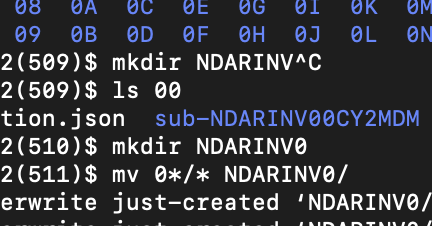

## INFANT 

### get infant dataframe first

In [30]:
##let's try the infant thing (when making)
#이미 해서 저장해둠 

#infant data 
#import sys 
#import pandas as pd 
#curr_dir = os.getcwd()
#get_infant_thing = '/work2/08834/tg881334/stampede2/CHA_preproc/IMP_shell_scripts/IMP_MAIN_REAL_every_preprocessing/'
#
#
#sys.path.append(get_infant_thing)
#
#os.chdir(get_infant_thing) #so that the thing works
#
#import REAL_step0_get_infant_adult_df as wow
#
#infant_pd, adult_pd = wow.get_info()()
#
#infant_df_list = []
#adult_df_list = []
#for year in infant_pd.keys():
#    infant_df_list.append(infant_pd[year].rename(columns = {"Unnamed: 0" : "파일 유무"})) #Unnamed : 0 으로 되어있는 것들을 파일유무라는 것으로 rename을 다시하기
#    
#for year in adult_pd.keys():
#    adult_df_list.append(adult_pd[year].rename(columns = {"Unnamed: 0" : "파일 유무"})) #Unnamed : 0 으로 되어있는 것들을 파일유무라는 것으로 rename을 다시하기
#
##concat the things
#infant_df_total = pd.concat([i for i in infant_df_list])
#adult_df_total = pd.concat([i for i in adult_df_list])
#total_df = pd.concat([infant_df_total, adult_df_total])
#
#
#infant_df_total_2 = infant_df_total.copy()
#
#def sub_name(name):
#    new_name = 'sub-' + name.split('-')[0][2:] + name.split('-')[1][1:]
#    return new_name
#
#infant_df_total_2['영상파일 번호'] =  infant_df_total['영상파일 번호'].apply(sub_name)
#
#infant_df_total_2

In [4]:
##the infant_df_total_2 is our thing!
#infant_df_total_2.to_csv('/work2/08834/tg881334/stampede2/ABCD_preproc/IMP_ABCD_preproc/infant_pd.csv')

In [21]:
import pandas as pd 
infant_df = pd.read_csv('/work2/08834/tg881334/stampede2/ABCD_preproc/IMP_ABCD_preproc/infant_pd.csv')

In [23]:
#infant run ##NOT DONE YET! DO IN 1 HR!
infant_age_list = [i for i in os.listdir("/scratch/08834/tg881334/CHA_preproc/2.BIDS") if float(i.split('_')[3]) <=4.5 ]
infant_age_list.sort()


for i,age in enumerate(['age_1_to_1.5_2', 'age_2_to_2.5_2', 'age_4_to_4.5_0','age_4_to_4.5_1']):#enumerate(infant_age_list):
        
    save_dir = f"/scratch/08834/tg881334/CHA_preproc/3.FS_tar/{age}"
    os.makedirs(save_dir,exist_ok= True)
    infant_fs = Args(scratch_dir='/scratch/08834/tg881334/CHA_preproc/2.BIDS/',
                        save_dir= save_dir, shell_name = 'step1_cha_infant_remainder', 
                        age_df = infant_df,
                        T2 = False, optional_BIDS_folder=age) #adult는 age 상관없으니 (infant fs에서만 age가 변수로 들어감)
    print(age)
    
    recon_all(infant_fs).make_scripts()
    


age_1_to_1.5_2
creating freesurfer .sh for subject : sub-101497
creating freesurfer .sh for subject : sub-101518
creating freesurfer .sh for subject : sub-101729
creating freesurfer .sh for subject : sub-111162
creating freesurfer .sh for subject : sub-111187
creating freesurfer .sh for subject : sub-111578
creating freesurfer .sh for subject : sub-121218
creating freesurfer .sh for subject : sub-131634
creating freesurfer .sh for subject : sub-131701
creating freesurfer .sh for subject : sub-131706
creating freesurfer .sh for subject : sub-140995
creating freesurfer .sh for subject : sub-141011
creating freesurfer .sh for subject : sub-141017
creating freesurfer .sh for subject : sub-141037
creating freesurfer .sh for subject : sub-150753
creating freesurfer .sh for subject : sub-150758
creating freesurfer .sh for subject : sub-150833
creating freesurfer .sh for subject : sub-160451
creating freesurfer .sh for subject : sub-160471
creating freesurfer .sh for subject : sub-160541
creat

In [ ]:
##additional files to do
folder_list = ['age_1_to_1.5_2', 'age_2_to_2.5_2', 'age_4.5_to_5_0', 'age_4.5_to_5_1', 'age_4_to_4.5_0','age_4_to_4.5_1']

In [14]:
##testing

#let's do first thing 
age = 'age_0_to_1_0'


infant_args = Args(scratch_dir='/scratch/08834/tg881334/CHA_preproc/2.BIDS/',
                        save_dir= f"/scratch/08834/tg881334/CHA_preproc/3.FS_tar/{age}", 
                       age_df = infant_df, shell_name = 'step1_cha_infant_sample',
                        T2 = False, optional_BIDS_folder=age)
recon_all(infant_args).make_scripts()

creating freesurfer .sh for subject : sub-101464
creating freesurfer .sh for subject : sub-110967
creating freesurfer .sh for subject : sub-111805
creating freesurfer .sh for subject : sub-121140
creating freesurfer .sh for subject : sub-121179
creating freesurfer .sh for subject : sub-121204
creating freesurfer .sh for subject : sub-130675
creating freesurfer .sh for subject : sub-131289
creating freesurfer .sh for subject : sub-131297
creating freesurfer .sh for subject : sub-131343
creating freesurfer .sh for subject : sub-131350
creating freesurfer .sh for subject : sub-131715
creating freesurfer .sh for subject : sub-140950
creating freesurfer .sh for subject : sub-140962
creating freesurfer .sh for subject : sub-140979
creating freesurfer .sh for subject : sub-140989
creating freesurfer .sh for subject : sub-141020
creating freesurfer .sh for subject : sub-141022
creating freesurfer .sh for subject : sub-141027
creating freesurfer .sh for subject : sub-141080
creating freesurfer 

In [ ]:
exit()

In [17]:
args = Args()
recon_all(args).make_scripts()


creating qsiprep .sh for subject : sub-111534
creating qsiprep .sh for subject : sub-131280
creating qsiprep .sh for subject : sub-150901


('/scratch/08834/tg881334/CHA_preproc_REAL/2.BIDS/sub-150901/anat/sub-150901_T1w.nii.gz',
 None,
 ['#! /bin/bash',
  'module load tacc-singularity',
  'singularity run -B /scratch/08834/tg881334/CHA_preproc_REAL/2.BIDS/sub-150901/anat:/data,/work2/08834/tg881334/stampede2/infant_FS:/supp --env FS_LICENSE=/supp/license.txt /work2/08834/tg881334/stampede2/CHA_preproc/docker/freesurfer_7.1.1.sif recon-all -sd /tmp -i /data/sub-150901_T1w.nii.gz -s sub-150901 -all -parallel -openmp 4 -no-isrunning'],
 4,
 'sub-150901')

In [4]:
#여러명에 대해서 실제로 돌릭 ㅣ


### trying with different  (T1,T2)


In [ ]:
num_subs = 0
for age_range in age_list:
    args = Args(age_range=age_range)
    print(args.sub_list)
    
    ####shell file folders
    
    ##위의 것들을 필요한 부분들만 들어서 txt file로 만들자
    #단, mkdir, file_path등은 python내에서 자체적으로 하기 
    
    sing_img_dir = args.supp_dir/"qsiprep-0.14.3.sif"#singularity image directory (0.14.3.sif for this one )
    
    os.makedirs(args.shell_dir, exist_ok = True)
    os.makedirs(args.save_dir, exist_ok = True)
    for sub in args.sub_list:
        print(f"creating qsiprep .sh for subject : {sub}")
        
        sub_BIDS_dir = str(args.BIDS_dir / sub)
        sub_save_dir = str(args.save_dir / sub)
        bash_shell = ["#! /bin/bash", "module load tacc-singularity"]
        os.mkdir(args.save_dir/sub)
        
        singularity_command = f"singularity run --cleanenv -B {sub_BIDS_dir}/:/data:ro,{sub_save_dir}/:/out,{str(args.supp_dir)}:/freesurfer {sing_img_dir} /data /out participant -w /out/tmp --output_resolution 1.2 --denoise_after_combining --unringing_method mrdegibbs --b0_to_t1w_transform Affine --intramodal_template_transform SyN --do_reconall --fs-license-file /freesurfer/license.txt --skip_bids_validation" #removeed nthreads because we want to use all available
        if args.infant == True : singularity_command = singularity_command + ' --infant' #add infant option of doing infant 
        ###tr this
        singularity_command = singularity_command + f' --nthreads {qsiprep_nthreads_per_sub}'
        
        bash_shell.append(singularity_command)
        #print(f"bash_shell {bash_shell}")
        
        ##saving the shell files
        with open(f"{args.shell_dir}/run_shell_{sub}.sh", "a") as f:
            for line in bash_shell:
                f.write(f"{line}\n")
    
    subprocess.run(f"chmod 755 {args.shell_dir}/*", shell = True)
    
    ##############IMPLEMENT : ACTUALLLY SAVING THE THING############3
    #print("hihi")
    os.makedirs(args.log_dir, exist_ok = True)
    for sub_shell in os.listdir(args.shell_dir):
        shell_to_run = os.path.join(args.shell_dir, sub_shell)
        sub_id = sub_shell.split('-')[-1][:-3]
        command_to_add = shell_to_run + f" >> {args.log_dir}/output-${{LAUNCHER_TSK_ID}}_sub-{sub_id}"
        #print(command_to_add)
        with open(f"{args.base_dir}/step4_shell_outputs/qsipreproc_command_list.txt", "a") as f:
            f.write(f"{command_to_add}\n")
    
    num_subs+=len(args.sub_list) #addition over all age groups 
import math

#num_subs = num_subs + 1 #had to do +1 to get every subject to be done (one process seems to be reserfved for running the thing as a whole)
num_nodes = int(math.ceil(float(num_subs)/ntasks_per_node)) #number of nodes to take, with ntasks per node satisfiedceiling으로 필요한 만큼 node가져가기
subprocess.run(f"sbatch -n {num_subs} -N {num_nodes} {args.base_dir}/REAL_activate_step4.sh", shell = True)
#added -n {num_subs} so that it automatically chooses the right number of jobs (slurm number of jobs)
pdb.set_trace()
    #pdb.set_trace()




